In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.


Three passes (iterations) are conducted. 

FIRST PASS (background field): Estimate analysis values at analysis grid via Cressman weighting function

SECOND PASS: Estimate analysis values at analysis grid using background grid, analysis values estimated to obs locations, and the Cressman weighting function

THIRD PASS: Similar to second pass, except with output from second pass instead of the background grid

INPUTS:
- 500 hPa height data from radiosonde observations

OUTPUTS:
- 500 hPa height analyses with one, two, and three passes
- Differences between second and first, third and first, and third and second analyses
- Root mean squares for each pass

Edits made by Alec Sczepanski for homework purposes. Special thanks to Andrew Kramer and Brian Horan for help 
figuring out some of the logic for passes 2 and 3, and for help troubleshooting.

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

###########################################################################################
# EDITS FOR HOMEWORK PURPOSES MADE BY ALEC SCZEPANSKI                                     #
#                                                                                         #
# ATSC 528 ASSIGNMENT #2                                                                  #
###########################################################################################

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

import pandas as pd

In [3]:
### Create function for Cressman Analysis ###
def cressman(ROI_ratio, d_min, d_ik):
    
    ''' 
    Function to analyze the value at a given point from other data
    using a Cressman analysis technique.
    
    INPUT:
    ROI_ratio = Radius of Influence ratio (to be multiplied by d_min)
    d_min = avg distance between the nearest radiosondes in data set
    d_ik = distance between i-th analysis point and k-th observation point
    
    OUTPUT:
    Cressman weight function (w)
    '''
    
    # Calculate the radius of influence:
    ROI = ROI_ratio * d_min
    
    # Calculate 'w':
    if d_ik > ROI:
        
        w = 0
    
    else:
        
        w = (ROI**2 - d_ik**2) / (ROI**2 + d_ik**2)
        
    return w
    

In [4]:
### Create function for bilinear interpolation ###
     
    
def bilinear_interp(x, y, fA):
    
    '''
    Function to perform bilinear interpolation.
    
    INPUTS:
    x = indices of the x coordinate of the desired obs locations
    y = indices of the y coordinate of the desired obs locations
    fA = analysis values at the analysis points
    
    OUTPUT:
    F = resulting estimate analysis value at the obs location
    '''
    
    # Find local x, y indices to work with:
    local_x = x - np.floor(x)
    local_y = y - np.floor(y)
    
    # Find analysis values for the four corners of the box:
    F_1 = fA[int(np.floor(y)), int(np.floor(x))]
    F_2 = fA[int(np.ceil(y)), int(np.floor(x))]
    F_3 = fA[int(np.ceil(y)), int(np.ceil(x))]
    F_4 = fA[int(np.floor(y)), int(np.ceil(x))]
    
    # Next, will calculate the individual terms of the bilinear interpolation equation.
    # NOTE: The four corners of the square [(x_1, y_1), (x_1, y_2), (x_2, y_2), and (x_2, y_1)]
    # can be simplified to [(0,0), (0,1), (1,1), (1,0)] since we are worried about the local
    # indices, which are found via the local_x and local_y above. Thus, will plug in these
    # values for x_1, x_2, y_1, and y_2.
    
    # Calculate term 1 [(x - x_2)(y - y_2)F_1]
    T1 = (local_x - 1)*(local_y - 1)*F_1
    
    # Calculate term 2 [(x - x_1)(y - y_2)F_2]
    T2 = (local_x)*(local_y - 1)*F_2
    
    # Calculate term 3 [(x - x_1)(y - y_1)F_3]
    T3 = (local_x)*(local_y)*F_3
    
    # Calculate term 4 [(x - x_2)(y - y_1)F_4]
    T4 = (local_x - 1)*(local_y)*F_4
    
    # Now will combine these terms in the final equation. 
    # NOTE: The term 1/(dxdy) equals 1 in this case since dx = 1-0 and dy = 1-0, making dxdy = 1 and 1/dxdy = 1.
    # Thus, the term 1/(dxdy) is not shown below.
    
    F = (T1 - T2) + (T3 - T4)
    
    return F
    

In [5]:

# Create functions for first and subsequent passes:

def first_pass(w, f_O):
    
    '''
    Function to compute the first pass Cressman.
    Also used to help fill in data holes where obs are outside analysis domain in second and third passes.
    
    INPUTS:
    w: weights output from cressman() function
    f_O: observations
    
    OUTPUT:
    f_A: analysis values
    '''
    
    w = np.array(w)
    
    f_A = np.sum(w*f_O)/np.sum(w)
    
    return f_A


def subsequent_pass(w, f_O, f_A_ri, f_A_rk):
    
    '''
    Function to compute subsequent passes on data.
    
    INPUTS:
    w: weights output from cressman() function
    f_O: observations
    f_A_ri: analysis values from the (j-1)th pass
    f_A_rk: estimated analysis values at the observation locations from the (j-1)th pass
    
    OUTPUT:
    f_A: analysis values for the j-th pass
    '''
    
    w = np.array(w) 

    f_A = f_A_ri + (np.nansum(w*(f_O - f_A_rk))/np.sum(w))
    
    return f_A

In [6]:
### Read in observations ###

# Establish column names:
col_names = ['station', 'latitude',
             'longitude', 'height',
             'wind_dir', 'wind_spd']

# Read in data:
df = pd.read_csv('RAOBs_201903131200.txt',
                 names = col_names)

# Establish variables:
station_id = df['station']
latitude = df['latitude']
longitude = df['longitude']
height = df['height']
dd = df['wind_dir']
ff = df['wind_spd']

In [7]:
### Set up analysis map with a 22x28 rectangular grid of points ###

# Some constants:
dx = 1.27 #in cm
dy = 1.27 #in cm
x_0 = 18.9 #in cm; upper left corner
y_0 = -6.3 #in cm; upper left corner

# Set up x and y intervals for grid:
x_i = x_0 + (np.arange(22)*dx)
y_j = y_0 + (np.arange(28)*dy)

# Combine x_i and y_j into a grid:
x_grid, y_grid = np.meshgrid(x_i, y_j)

In [8]:
### convert obs lat/long to x,y ###

# Convert observation lat and lon to x and y coordinates:
R = 637100000 #radius of Earth in centimeters
phi_O_rad = 60*(np.pi/180) #standard latitude in radians
lam_O = -115*(np.pi/180) #reference longitude in radians
m = 1/15000000 #map projection
lat_rad = latitude*(np.pi/180) #latitudes in radians
lon_rad = longitude*(np.pi/180) #Longitude in radians
sigma = (1 + np.sin(phi_O_rad))/(1 + np.sin(lat_rad))


# Calculate observation lat, lon in x, y coordinates:
r = m*(R*sigma*np.cos(lat_rad))
x_obs = r*(np.cos(lon_rad - lam_O))
y_obs = r*(np.sin(lon_rad - lam_O))

In [9]:
### Perform 500mb geopotential height analyses using a Cressman weighting Function###
#Use radii of influence 4, 2.5, 1.5 *dmin


# First, will find d_min:
d_min = []

# Loop through gridded points:
for i in range(len(x_obs)):
        
    # Calculate x_k and y_k, which are the difference between
    # x_obs, y_obs, and analysis point coordinates:
    X_k = x_obs[i] - x_obs
    Y_k = y_obs[i] - y_obs
        
    # Calculate magnitude of these differences:
    magnitude = (X_k**2 + Y_k**2)**(1/2)
        
    # Remove any zeroes from array:
    magnitude = magnitude[magnitude != 0]
        
    # Find minimum and append to d_min:
    d_min += [np.min(magnitude)]

# Take average of d_min:
d_min = np.mean(d_min)


In [10]:
# Make array to save analysis values into:

# First pass (ROI = 4*d_min)
fA_ri1 = np.full((len(y_j), len(x_i)), -999.9)

In [11]:
### First analysis, no successive corrections ###

# Loop through gridded points:
for i in range(len(x_grid)):
    for j in range(len(x_grid[i])):
        
        # Calculate x_k and y_k, which are the difference between
        # x_obs, y_obs and the analysis point coordinates
        X_k = x_grid[i][j] - x_obs
        Y_k = y_grid[i][j] - y_obs
        
        # Calculate the magnitude of these differences:
        d_ik = (X_k**2 + Y_k**2)**(1/2)
            
        # Create empty lists to store outputs from Cressman weighting:
        w_4 = []
        
        # Loop through d_ik:
        for k in d_ik:
            
            w_4 += [cressman(ROI_ratio = 4, d_min = d_min, d_ik = k)]
            
        
        fA_ri1[i][j] = first_pass(w_4, height)

In [12]:
### Next Analyses ###

# Establish arrays to hold second and third pass outputs:
# Second pass (ROI = 2.5*d_min):
fA_ri2 = np.full((len(y_j), len(x_i)), -999.9)

# Third pass (ROI = 1.5*d_min):
fA_ri3 = np.full((len(y_j), len(x_i)), -999.9)

In [13]:
# Set up list to house bilinearly interpolated analysis values at observation locations:
fA_rk1 = []
fA_rk2 = []

#############
# SECOND PASS

# Determine index values for x_obs and y_obs:
x_index = (x_obs - x_0) / 1.27 #cm
y_index = (y_obs - y_0) / 1.27 #cm

# Next, will determine if the observations are within the domain.
# Domain indices: 
#  x: 0-21
#  y: 0-27
for i in range(len(x_index)):
    
    # If observation location within domain, run through bilinear interpolation:
    if (0 < x_index[i] < 21) and (0 < y_index[i] < 27):
        
        p = bilinear_interp(x_index[i], y_index[i], fA_ri1)
        
    # If observation is NOT within the domain, perform Cressman:
    else:
        local_x = x_obs[i] - x_grid
        local_y = y_obs[i] - y_grid
        
        # Get local d_ik:
        local_d_ik = (local_x**2 + local_y**2)**(1/2)
        
        # Find obs points where there are analysis points are within ROI (4*d_min):
        indices_in_ROI = np.where(local_d_ik <= 4*d_min)
        
        # Establish array to hold weights:
        local_weights = np.zeros((x_grid.shape))
        
        # Loop through found points:
        for j in indices_in_ROI[0]:
            for k in indices_in_ROI[1]:
                
                local_weights[j][k] = cressman(ROI_ratio = 4, d_min = d_min, d_ik = local_d_ik[j][k])
                
        p = first_pass(local_weights, fA_ri1)
        
    fA_rk1 += [p]
    
    
# Convert fA_rk1 to an array:
fA_rk1 = np.array(fA_rk1)

# Now, will calculate fA_ri2:
# Loop through gridded points:
for i in range(len(x_grid)):
    for j in range(len(x_grid[i])):
        
        # Calculate x_k and y_k, which are the difference between
        # x_obs, y_obs and the analysis point coordinates
        X_k = x_grid[i][j] - x_obs
        Y_k = y_grid[i][j] - y_obs
        
        # Calculate the magnitude of these differences:
        d_ik = (X_k**2 + Y_k**2)**(1/2)
        
        # Create empty lists to store outputs from Cressman weighting:
        w_25 = []
        
        # Loop through d_ik:
        for k in d_ik:
            
            w_25 +=[cressman(ROI_ratio = 2.5, d_min = d_min, d_ik = k)]
            
        fA_ri2[i][j] = subsequent_pass(w_25, height, fA_ri1[i][j], fA_rk1)
        

C:\Users\sczep\AppData\Local\Temp/ipykernel_7552/319774051.py:19: RuntimeWarning: invalid value encountered in double_scalars
  f_A = np.sum(w*f_O)/np.sum(w)


In [14]:
#############
# THIRD PASS

# Will determine if the observations are within the domain.
for i in range(len(x_index)):
    
    # If observation location within domain, run through bilinear interpolation:
    if (0 < x_index[i] < 21) and (0 < y_index[i] < 27):
        
        p = bilinear_interp(x_index[i], y_index[i], fA_ri2)
        
    # If observation is NOT within the domain, perform Cressman:
    else:
        local_x = x_obs[i] - x_grid
        local_y = y_obs[i] - y_grid
        
        # Get local d_ik:
        local_d_ik = (local_x**2 + local_y**2)**(1/2)
        
        # Find obs points where there are analysis points are within ROI (2.5*d_min):
        indices_in_ROI = np.where(local_d_ik <= 2.5*d_min)
        
        # Establish array to hold weights:
        local_weights = np.zeros((x_grid.shape))
        
        # Loop through found points:
        for j in indices_in_ROI[0]:
            for k in indices_in_ROI[1]:
                
                local_weights[j][k] = cressman(ROI_ratio = 2.5, d_min = d_min, d_ik = local_d_ik[j][k])
                
        p = first_pass(local_weights, fA_ri2)
        
    fA_rk2 += [p]
    
# Convert fA_rk2 to an array:
fA_rk2 = np.array(fA_rk2)

# Now, will calculate fA_ri3:
# Loop through gridded points:
for i in range(len(x_grid)):
    for j in range(len(x_grid[i])):
        
        # Calculate x_k and y_k, which are the difference between
        # x_obs, y_obs and the analysis point coordinates
        X_k = x_grid[i][j] - x_obs
        Y_k = y_grid[i][j] - y_obs
        
        # Calculate the magnitude of these differences:
        d_ik = (X_k**2 + Y_k**2)**(1/2)
            
        # Create empty lists to store outputs from Cressman weighting:
        w_15 = []
        
        # Loop through d_ik:
        for k in d_ik:
            
            w_15 += [cressman(ROI_ratio = 1.5, d_min = d_min, d_ik = k)]
            
        fA_ri3[i][j] = subsequent_pass(w_15, height, fA_ri2[i][j], fA_rk2)

C:\Users\sczep\AppData\Local\Temp/ipykernel_7552/319774051.py:19: RuntimeWarning: invalid value encountered in double_scalars
  f_A = np.sum(w*f_O)/np.sum(w)
C:\Users\sczep\AppData\Local\Temp/ipykernel_7552/319774051.py:41: RuntimeWarning: invalid value encountered in double_scalars
  f_A = f_A_ri + (np.nansum(w*(f_O - f_A_rk))/np.sum(w))


In [15]:
### Calculate Analysis Differences

# Difference between second and first pass:
fA_ri_d21 = fA_ri2 - fA_ri1

# Difference between third and first pass:
fA_ri_d31 = fA_ri3 - fA_ri1

# Difference between third and second pass:
fA_ri_d32 = fA_ri3 - fA_ri2

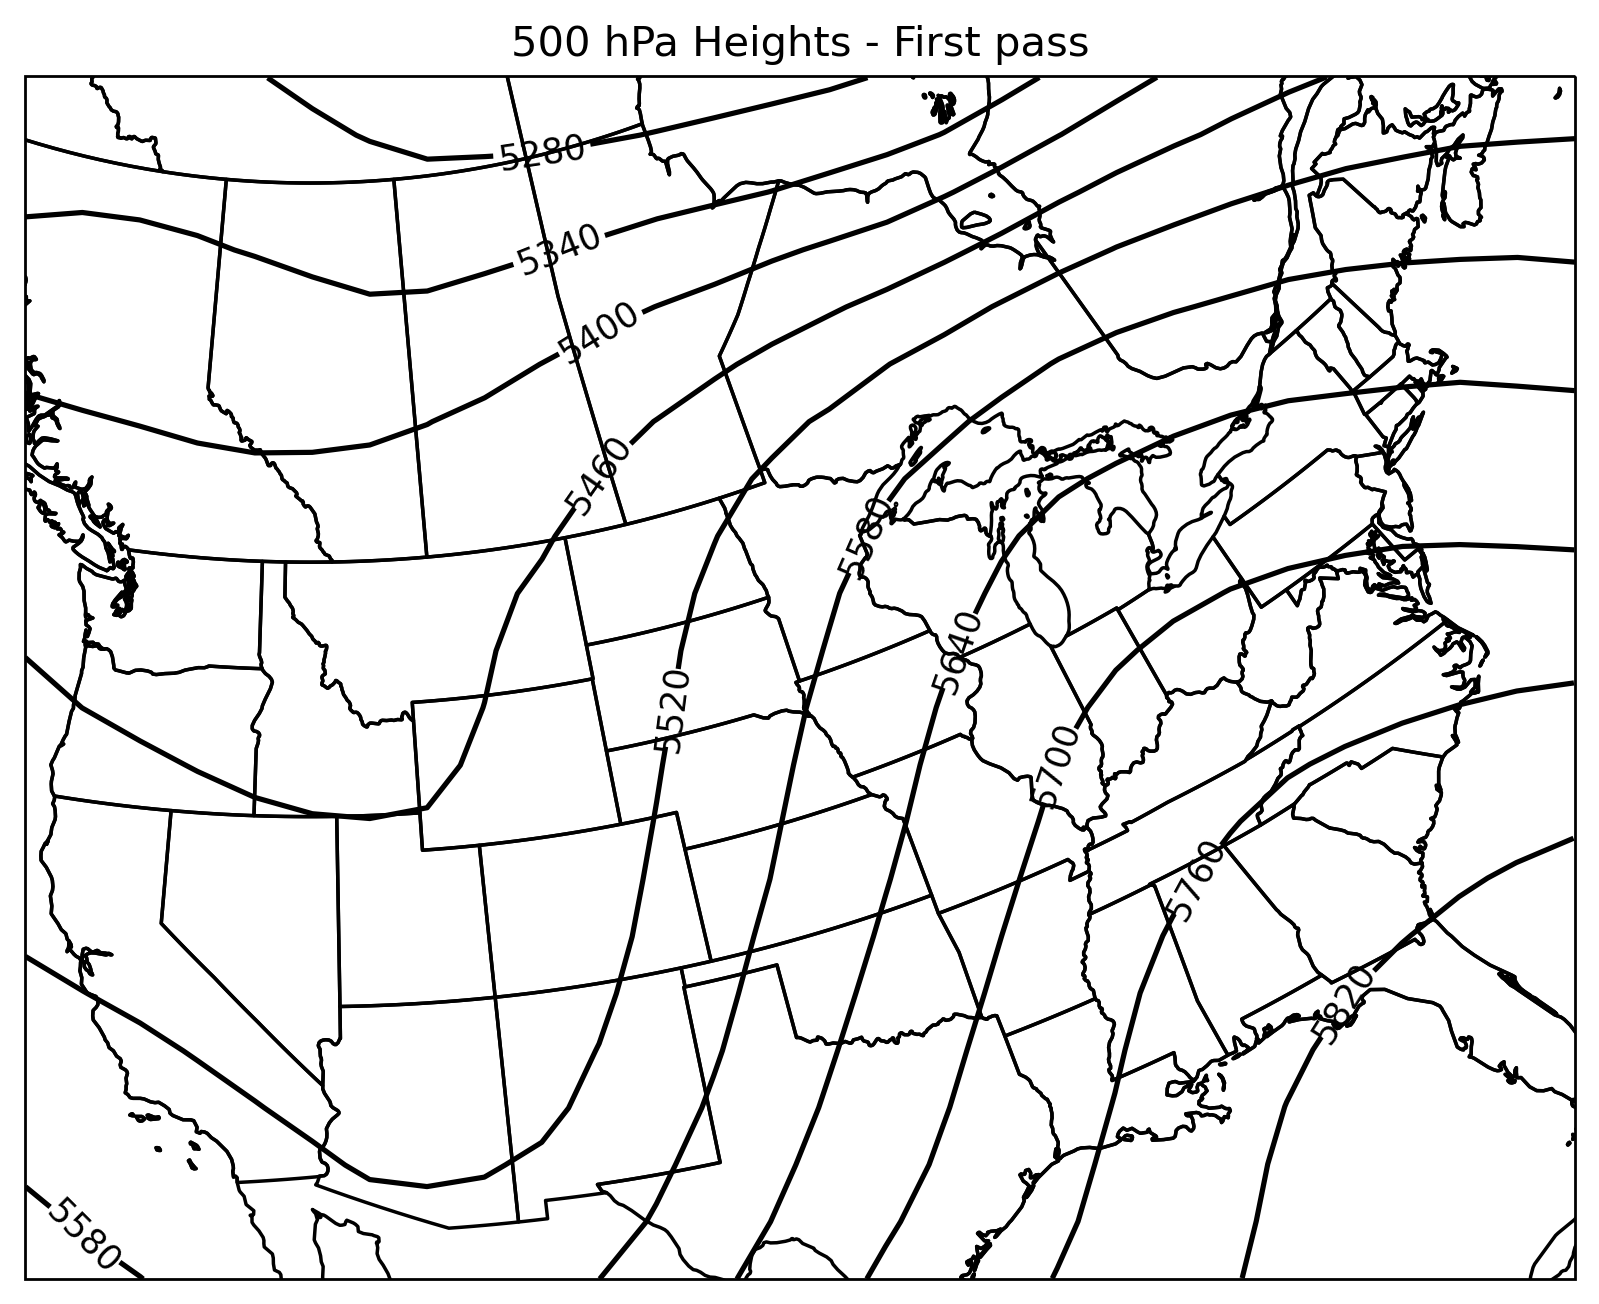

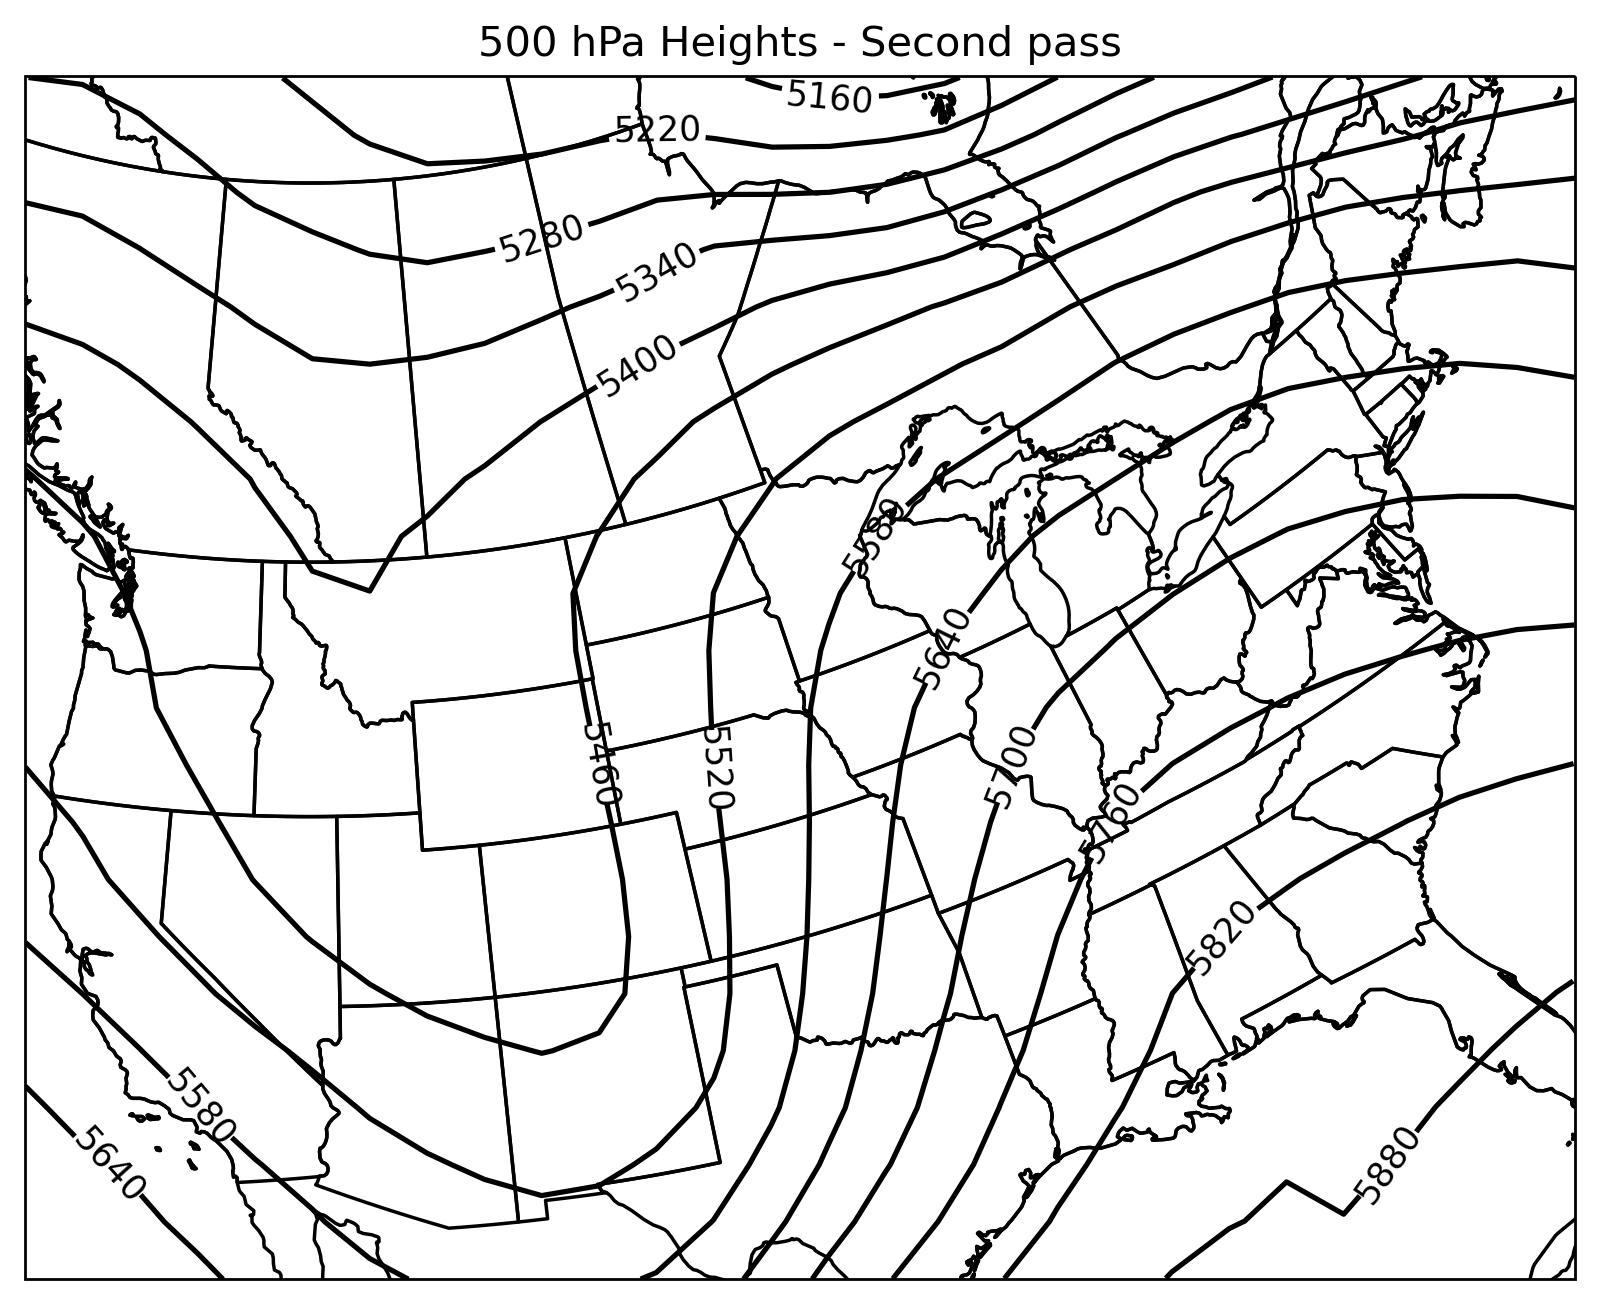

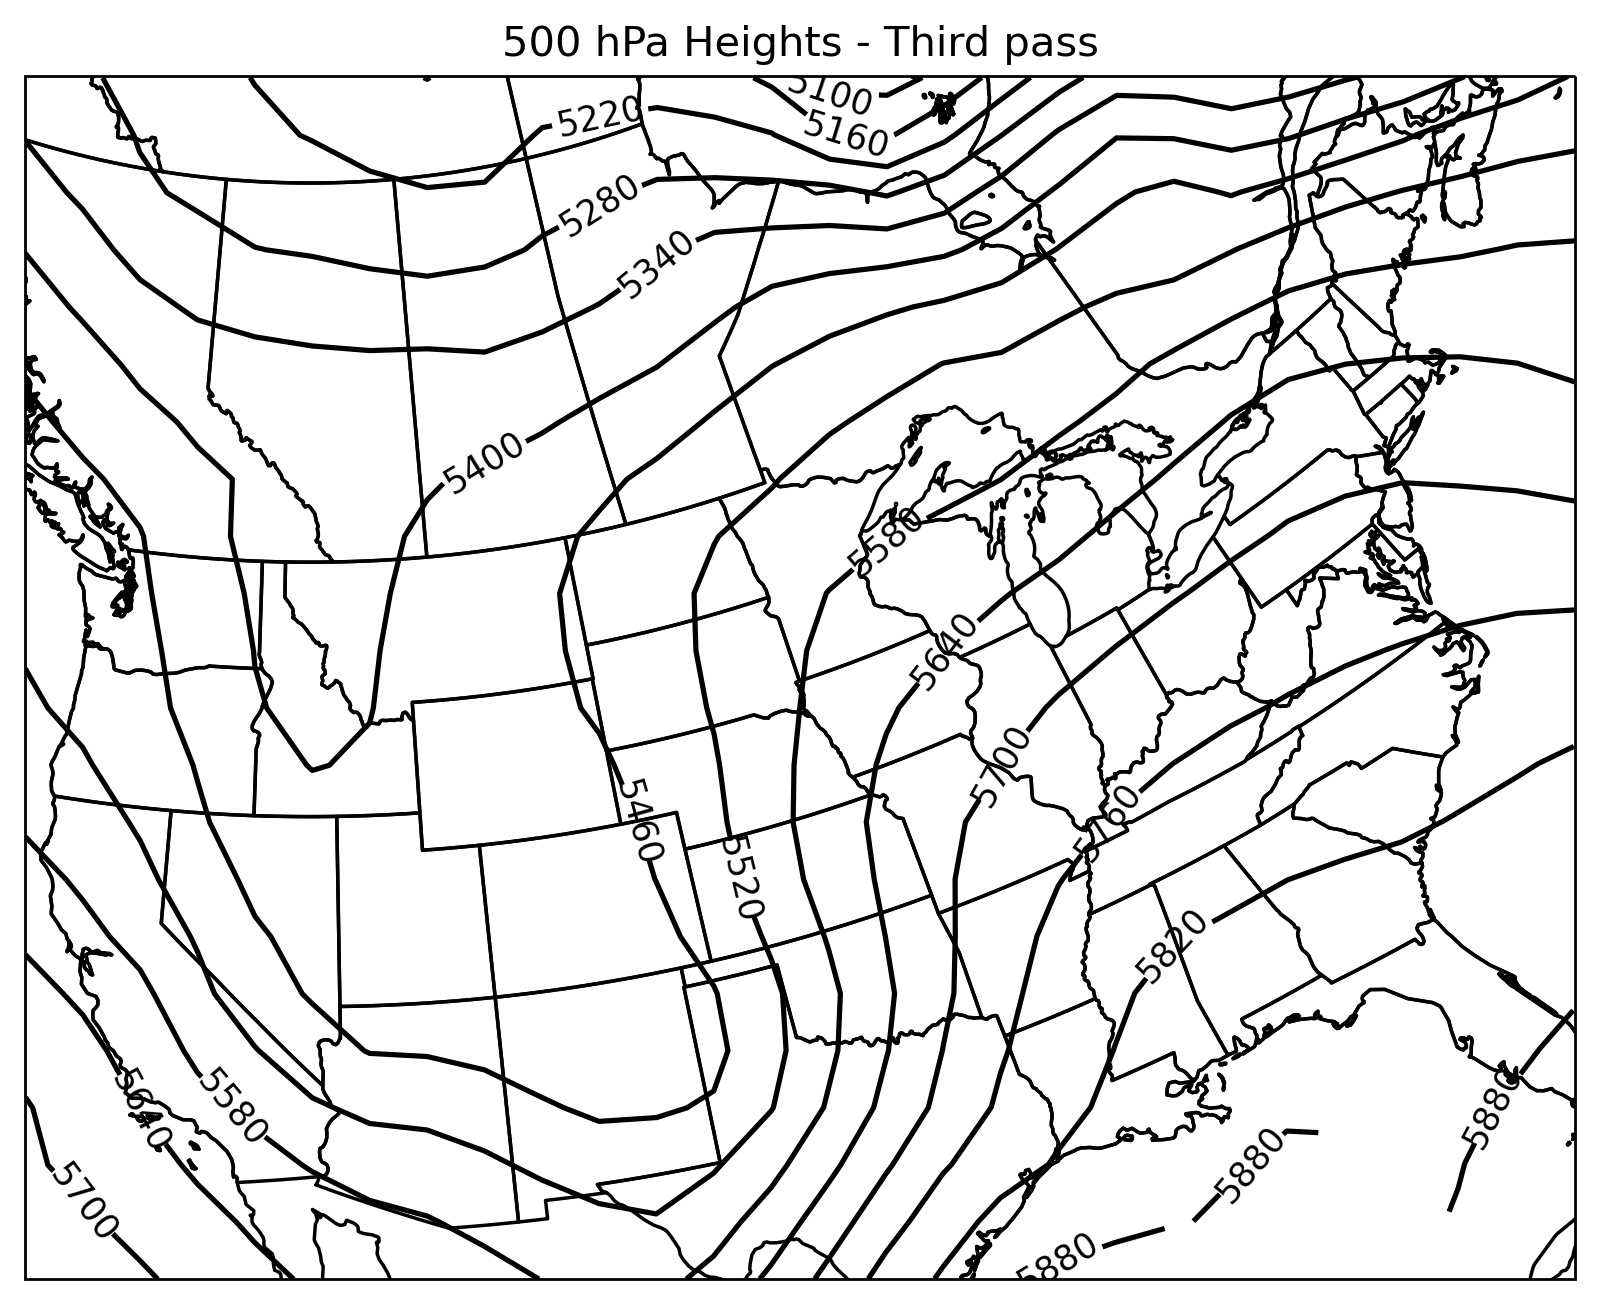

In [16]:
### Plot 500mb analyses over a map ###
#use old code...


# Convert gridded points to phi and lambda (lat, lon):
phi_grid = (np.pi/2) - (2*(np.arctan(np.sqrt((x_grid / m)**2 + (y_grid / m)**2) / (R*(1 + np.sin(phi_O_rad))))))
phi_grid = phi_grid * (180/np.pi)
lam_grid = (lam_O + np.arctan(y_grid/x_grid)) * (180/np.pi)

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)

######################
# First pass, ROI = 4d
fig = plt.figure(figsize=(8,8),dpi=250)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(lam_grid,phi_grid,fA_ri1,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('500 hPa Heights - First pass')

plt.savefig('Sczepanski_ATSC528_HW2_500hts_first_pass.png', dpi = 250)

######################
# Second pass, ROI = 2.5
fig = plt.figure(figsize=(8,8),dpi=250)
ax2 = fig.add_subplot(111,projection=proj)
ax2.add_feature(cfeature.STATES)
ax2.add_feature(cfeature.COASTLINE)

cs2 = ax2.contour(lam_grid,phi_grid,fA_ri2,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs2,levels=np.arange(0,8000,60))
plt.title('500 hPa Heights - Second pass')

plt.savefig('Sczepanski_ATSC528_HW2_500hts_second_pass.png', dpi = 250)

######################
# Third pass, ROI = 1.5
fig = plt.figure(figsize=(8,8),dpi=250)
ax3 = fig.add_subplot(111,projection=proj)
ax3.add_feature(cfeature.STATES)
ax3.add_feature(cfeature.COASTLINE)

cs3 = ax3.contour(lam_grid,phi_grid,fA_ri3,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs3,levels=np.arange(0,8000,60))
plt.title('500 hPa Heights - Third pass')

plt.savefig('Sczepanski_ATSC528_HW2_500hts_third_pass.png', dpi = 250)

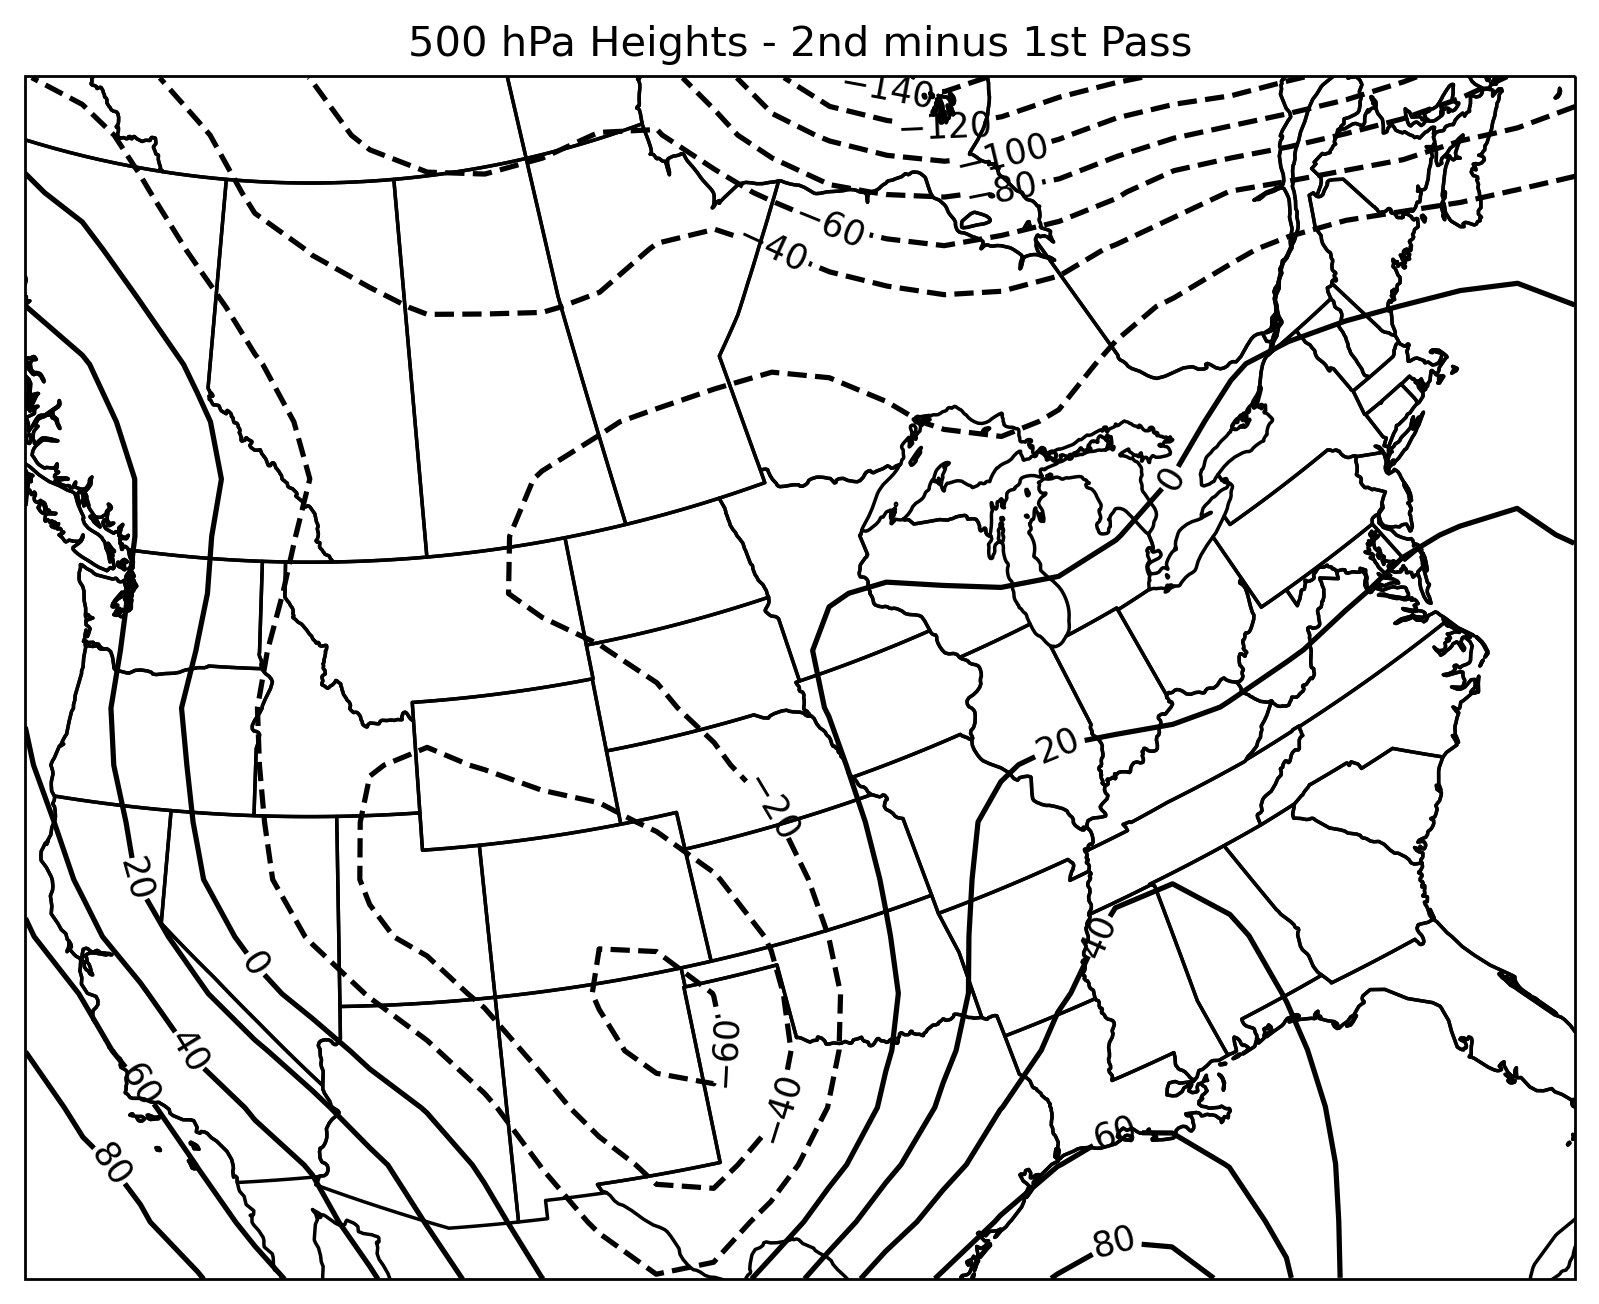

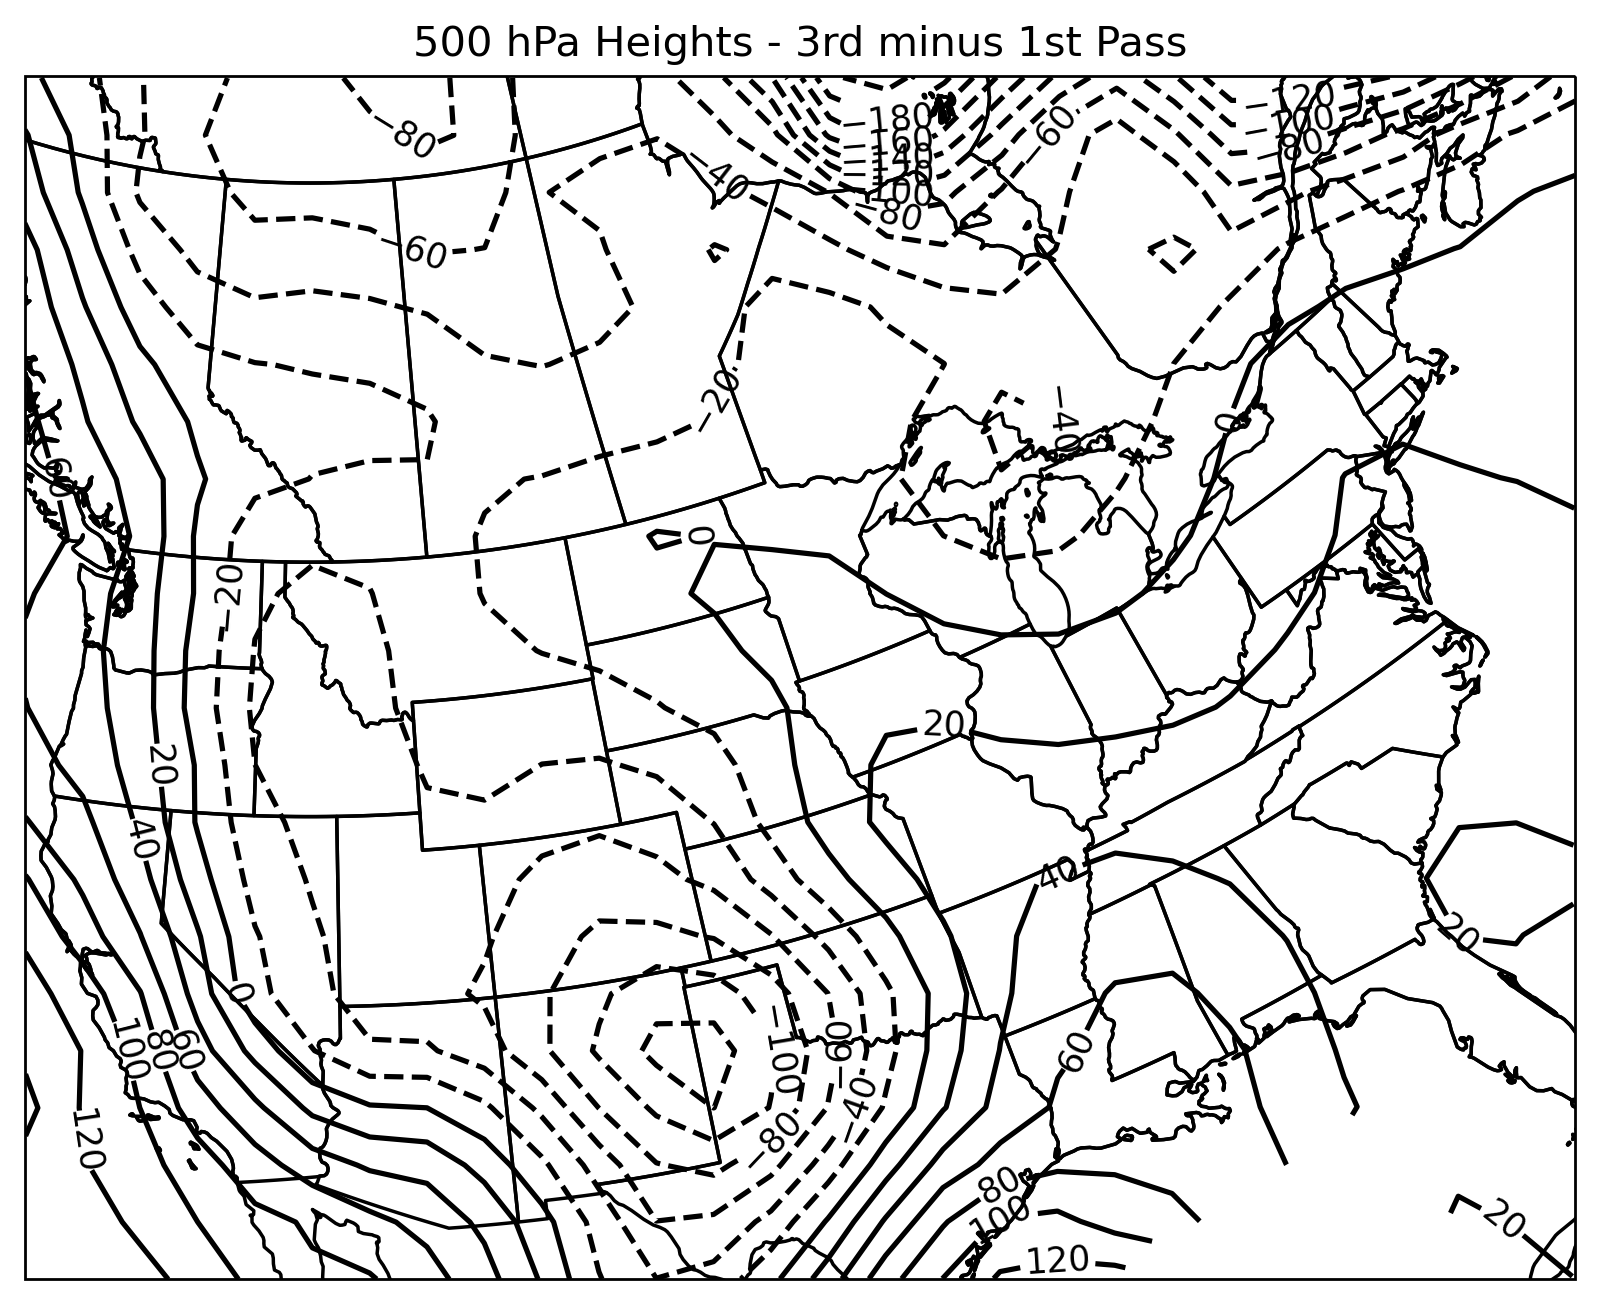

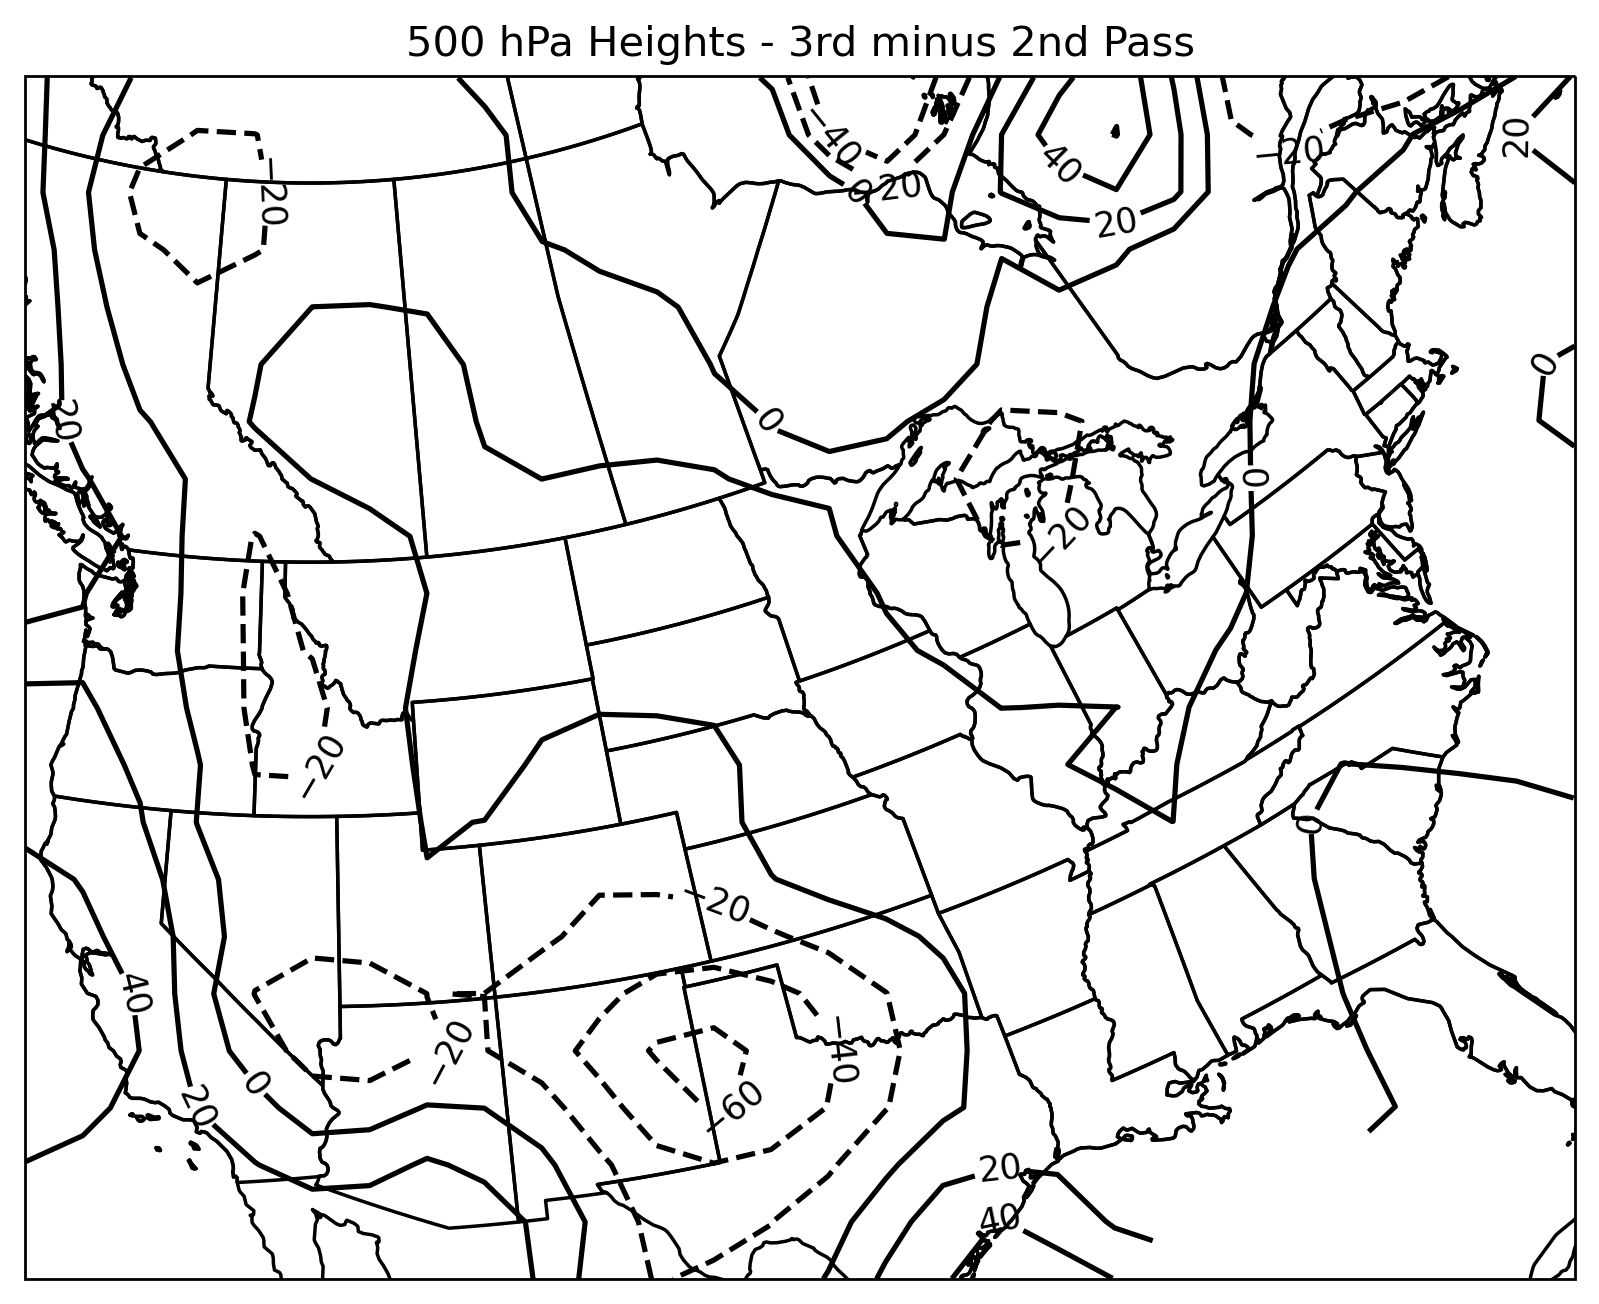

In [17]:
### Plot Analysis Differences ###

#####################
# Second - First pass
fig = plt.figure(figsize=(8,8),dpi=250)
ax4 = fig.add_subplot(111,projection=proj)
ax4.add_feature(cfeature.STATES)
ax4.add_feature(cfeature.COASTLINE)

cs4 = ax4.contour(lam_grid,phi_grid,fA_ri_d21,colors='k',levels=np.arange(-2000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs4,levels=np.arange(-2000,8000,20))
plt.title('500 hPa Heights - 2nd minus 1st Pass')

plt.savefig('Sczepanski_ATSC528_HW2_500hts_second_minus_first_pass.png', dpi = 250)


#####################
# Third - First pass
fig = plt.figure(figsize=(8,8),dpi=250)
ax5 = fig.add_subplot(111,projection=proj)
ax5.add_feature(cfeature.STATES)
ax5.add_feature(cfeature.COASTLINE)

cs5 = ax5.contour(lam_grid,phi_grid,fA_ri_d31,colors='k',levels=np.arange(-2000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs5,levels=np.arange(-2000,8000,20))
plt.title('500 hPa Heights - 3rd minus 1st Pass')

plt.savefig('Sczepanski_ATSC528_HW2_500hts_third_minus_first_pass.png', dpi = 250)


#####################
# Third - Second pass
fig = plt.figure(figsize=(8,8),dpi=250)
ax6 = fig.add_subplot(111,projection=proj)
ax6.add_feature(cfeature.STATES)
ax6.add_feature(cfeature.COASTLINE)

cs6 = ax6.contour(lam_grid,phi_grid,fA_ri_d32,colors='k',levels=np.arange(-2000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs6,levels=np.arange(-2000,8000,20))
plt.title('500 hPa Heights - 3rd minus 2nd Pass')

plt.savefig('Sczepanski_ATSC528_HW2_500hts_third_minus_second_pass.png', dpi = 250)

In [18]:
### Store the analyses in text files ###

np.savetxt('output_first_pass.txt', fA_ri1)
np.savetxt('output_second_pass.txt', fA_ri2)
np.savetxt('output_third_pass.txt', fA_ri3)

In [19]:
### Store the difference fields in text files ###

np.savetxt('output_diff_second_first_passes.txt', fA_ri_d21)
np.savetxt('output_diff_third_first_passes.txt', fA_ri_d31)
np.savetxt('output_diff_third_second_passes.txt', fA_ri_d32)

In [20]:
### Store RMS values in text file ###

def RMS(f_O, f_A_rk):
    
    '''
    Function to calculate RMS.
    
    INPUTS:
    f_O: observation data
    f_A_rk: estimated analysis data at observation locations
    
    OUTPUT:
    RMS: room mean square error
    '''
    
    numerator = (np.sum(f_O - f_A_rk))**2
    denominator = len(f_O)
    
    RMS = np.sqrt(numerator / denominator)
    
    return RMS


# Need to define an fA_rk3 for the third pass, so will do that first:

fA_rk3 = []

# Will determine if the observations are within the domain.
for i in range(len(x_index)):
    
    # If observation location within domain, run through bilinear interpolation:
    if (0 < x_index[i] < 21) and (0 < y_index[i] < 27):
        
        p = bilinear_interp(x_index[i], y_index[i], fA_ri3)
        
    # If observation is NOT within the domain, perform Cressman:
    else:
        local_x = x_obs[i] - x_grid
        local_y = y_obs[i] - y_grid
        
        # Get local d_ik:
        local_d_ik = (local_x**2 + local_y**2)**(1/2)
        
        # Find obs points where there are analysis points are within ROI (1.5*d_min):
        indices_in_ROI = np.where(local_d_ik <= 1.5*d_min)
        
        # Establish array to hold weights:
        local_weights = np.zeros((x_grid.shape))
        
        # Loop through found points:
        for j in indices_in_ROI[0]:
            for k in indices_in_ROI[1]:
                
                local_weights[j][k] = cressman(ROI_ratio = 1.5, d_min = d_min, d_ik = local_d_ik[j,k])
                
        p = first_pass(local_weights, fA_ri3)
        
    fA_rk3 += [p]
    
# Convert fA_rk2 to an array:
fA_rk3 = np.array(fA_rk3)


# Fave data needed ot calculate RMS, thus will do that now:
RMS_pass1 = RMS(height, fA_rk1)
RMS_pass2 = RMS(height, fA_rk2)
RMS_pass3 = RMS(height, fA_rk3)

RMS_array = np.array([RMS_pass1, RMS_pass2, RMS_pass3])

np.savetxt('output_RMS.txt', RMS_array)


In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    

3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?
    
***SEE 'Sczepanski_HW2_written_portion.txt' FOR MY ANSWERS TO THESE QUESTIONS.***
'''